In [1]:
# Understanding autoencoders via a simple example

In [97]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l
from itertools import product
from torch import nn

In [98]:
# I only need labels(sdf) here to form cubes 3d for each sample of ax, by, cz
# I need to have these inputs (cubes) into a CNN autoencoder and apply conv3d.
# Don't get fret if you see features=labels, as I'm using 'features' term for inputs.
# In previous attempts, I used occupany (x,y,z) and coef(ax, by, cz) and codes(3) and
# in total I end up having 3+3+3=9 params. But, it isn't good to have 9 params, 
# too much for further usages in real applications.
# (In real application like minimizing objective functions like Impedance, pressure
# drop, etc).
# I tested that in an autoDecoder. But now, I want to use Autodecoder to shorten the
# codes in bottelneck layer. Let's see how it goes...

In [136]:
from dataset.tig_based_dataset import (load_gyroid_sdf_dataset,
                                       load_primitive_sdf_dataset)

In [137]:
# gyroid-like
repeat = 3
num_coef_chuk = 5
axis_chuk = 50
coef=list(product(np.linspace(1,2, num_coef_chuk), repeat=repeat))
features1, labels1 = load_gyroid_sdf_dataset(coef=coef, axis_chuncks=axis_chuk)

In [235]:
len(coef)

125

In [236]:
features1.shape

torch.Size([15625000, 6])

In [237]:
labels1.shape

torch.Size([15625000])

In [238]:
# features = features1

In [239]:
labels1.reshape(num_coef_chuk**repeat, axis_chuk, axis_chuk, axis_chuk).shape

torch.Size([125, 50, 50, 50])

In [240]:
features  = labels1.reshape(num_coef_chuk**repeat, axis_chuk, axis_chuk, axis_chuk)

In [241]:
features.shape

torch.Size([125, 50, 50, 50])

In [242]:
# first_col_random = torch.rand(10,1) # producing a random column
# features = torch.cat((first_col_random, 2*first_col_random), 1) # that is how a relationship between cols 
# are introduced here in my example.

In [243]:
# # now, I want to have more columns. each colmn is multiplied from first column
# first_col_random = torch.rand(1000,1) 
# features = first_col_random # initial values for the fist col
# for i in range(2,5):
#     features = torch.cat((features, i*first_col_random), 1) # creation of other colmn

In [244]:
# see? they are multipied from the first col
# features

In [245]:
# first_col_random

In [246]:
# in auto encoder we want a reperesentation of our data. The best representation here is the one
# shows that colmns are multiplied from the first one (abvious). But this one seems like to be 
# an unsupervised learning. But no. Let's think differently. We want a representation x_ of our data x
# so, I guess now it is a supervised learning. We only need to define ground truth as y = x and
# come up with wieghts and biases (through training) to best fit this.

# based on the explanation above, let's figure this out:
labels = features

In [247]:
features.shape, labels.shape

(torch.Size([125, 50, 50, 50]), torch.Size([125, 50, 50, 50]))

In [248]:
# features[0], labels[0]

In [345]:
encoder = nn.Sequential(
    nn.Conv3d(in_channels=1, out_channels=25, kernel_size=(7,7,7), padding=3, padding_mode='circular'),
    nn.MaxPool3d(kernel_size=(2,2,2), stride=2),
    # nn.ReLU(),
    nn.Conv3d(in_channels=25, out_channels=1, kernel_size=(3,3,3), padding=1, padding_mode='circular'),
    nn.MaxPool3d(kernel_size=(2,2,2), stride=2),
    # nn.ReLU(),
    nn.BatchNorm3d(1)  ,
    nn.Flatten(start_dim=1),
    nn.Linear(1728,500),
    # nn.ReLU(),
    nn.Linear(500,80),
    # nn.ReLU(),
    nn.Linear(80,15),
    # nn.ReLU(),
    nn.Linear(15,3),    
    nn.Tanh(),
)

In [346]:
# encoder.state_dict()

In [347]:
features.shape

torch.Size([125, 1, 50, 50, 50])

In [348]:
features = features.reshape(125,1, 50,50,50).float()

In [349]:
# features[0]

In [350]:
encoder(features[0:1]).shape

torch.Size([1, 3])

In [351]:
encoder(features[0:10])

tensor([[ 0.1997,  0.1075,  0.0062],
        [ 0.1995,  0.1052, -0.0037],
        [ 0.1996,  0.1027, -0.0130],
        [ 0.2006,  0.1000, -0.0217],
        [ 0.2019,  0.0977, -0.0307],
        [ 0.2093,  0.0814,  0.0119],
        [ 0.2094,  0.0786,  0.0024],
        [ 0.2096,  0.0758, -0.0072],
        [ 0.2102,  0.0734, -0.0164],
        [ 0.2118,  0.0713, -0.0254]], grad_fn=<TanhBackward0>)

In [352]:
decoder = nn.Sequential(
    nn.Linear(3,10),
    
    nn.ReLU(True),
    nn.Linear(10,20),
    nn.ReLU(True),
    nn.Linear(20,270),
    nn.ReLU(True),
    nn.Unflatten(dim=1, unflattened_size=(10, 3, 3,3)),
                                   # [1, 1, 30, 3, 3]
    nn.ConvTranspose3d(10, 16, 3,  output_padding=0),
    # nn.BatchNorm2d(16),
    nn.ReLU(True),
    nn.ConvTranspose3d(16, 8, 3, stride=2, padding=0, output_padding=1),
    # # nn.BatchNorm2d(8),
    nn.ReLU(True),
    nn.ConvTranspose3d(8, 2, 3, stride=2, padding=1, output_padding=1),
    nn.ReLU(True),
    nn.ConvTranspose3d(2, 1, 3, stride=2, padding=0, output_padding=1)

)


In [295]:
inp = torch.tensor([[0.2, 0.8, 0.9]])
decoder(inp).shape

torch.Size([1, 1, 50, 50, 50])

## Reading the data set

In [296]:
[1, 1, 30, 3, 3]

[1, 1, 30, 3, 3]

In [297]:
def load_array(data_arrays, batch_size, is_train=True): #@save
    """Construct a PyTorch data iterator."""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)


In [298]:
batch_size = 10
data_iter = load_array((features, features), batch_size)

In [299]:
data_iter

In [300]:
# it is import to use iterator for that
# next(iter(data_iter))

In [301]:
features.shape

torch.Size([125, 1, 50, 50, 50])

## Defining the Model

In [302]:
#model = Autoencoder(encoded_space_dim=encoded_space_dim)
# encoder = encoder(features[0])
# decoder = decoder()
lr= 0.003
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

In [303]:
def train_epoch(encoder, decoder, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    for epoch in range(20):
        train_loss = []
        # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
        for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
            # Move tensor to the proper device
            image_batch = image_batch.to('cpu')
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Evaluate loss
            loss = loss_fn(decoded_data, image_batch)
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss.append(loss.detach().cpu().numpy())
            # Print batch loss
        print(f' epoch: {epoch}:  {np.mean(train_loss)}')
        

    return np.mean(train_loss)

In [304]:
loss_fn = torch.nn.MSELoss()

In [305]:
train_epoch(encoder=encoder, 
            decoder=decoder,  
            dataloader=data_iter, 
            loss_fn=loss_fn, 
            optimizer=optim)

 epoch: 0:  1.801883578300476
 epoch: 1:  1.7876091003417969
 epoch: 2:  1.7844170331954956
 epoch: 3:  1.6780542135238647
 epoch: 4:  1.4389528036117554
 epoch: 5:  1.2600939273834229
 epoch: 6:  1.2091008424758911
 epoch: 7:  1.13994300365448
 epoch: 8:  1.105690836906433
 epoch: 9:  1.071576714515686
 epoch: 10:  1.0426870584487915
 epoch: 11:  1.0113604068756104
 epoch: 12:  0.9935566186904907
 epoch: 13:  0.9691020250320435
 epoch: 14:  0.9564538598060608
 epoch: 15:  0.9328920841217041
 epoch: 16:  0.9277929067611694
 epoch: 17:  0.9151195287704468
 epoch: 18:  0.8944242000579834
 epoch: 19:  0.8831093907356262


0.8831094

In [306]:
def test_epoch(encoder, decoder, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to('cpu')
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [307]:
test_epoch(encoder, decoder, dataloader=data_iter, loss_fn=loss_fn)

tensor(0.8800)

In [308]:
from utils.plot import d3_plot

In [309]:
scalar_field = decoder(encoder(features[0:1])).reshape(50,50,50).detach().numpy()

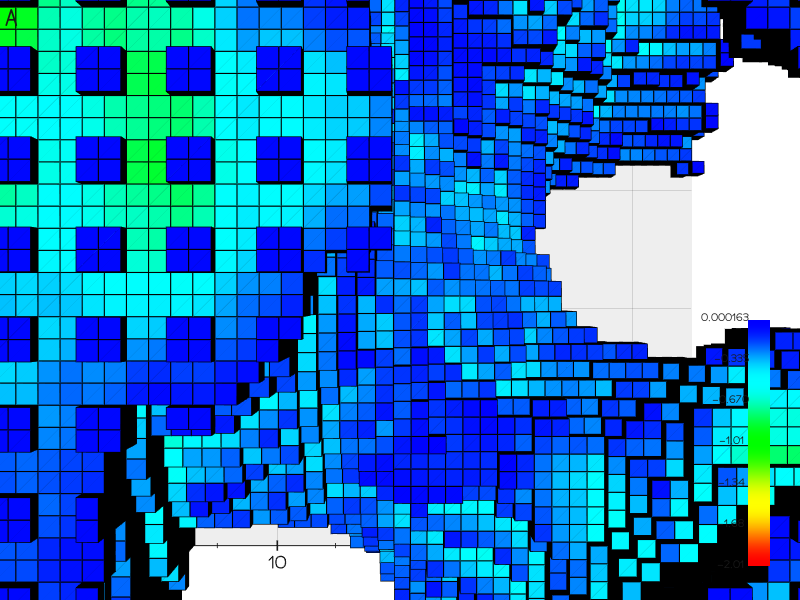

In [310]:
d3_plot(scalar_field)

In [311]:
# features[0:2, 0:2, 0:2, 0:2, 0:2]

In [314]:
print(encoder(features[0:10]).detach().numpy())

[[ 0.23796092 -0.46654508  0.062759  ]
 [ 0.20804963 -0.4250763   0.06002622]
 [ 0.17692406 -0.3804645   0.05727704]
 [ 0.11219519 -0.28326172  0.05188962]
 [-0.11002948  0.0095574   0.01196872]
 [ 0.20861845 -0.42626384  0.05982835]
 [ 0.17881875 -0.38352787  0.05725586]
 [ 0.12050113 -0.29634205  0.05239731]
 [-0.02834037 -0.07733874  0.03634141]
 [-0.2980441   0.22447495 -0.1459867 ]]


In [313]:
(encoder(features[0:1])).detach().numpy()

array([[ 0.23796092, -0.46654508,  0.062759  ]], dtype=float32)

In [366]:
# Center align images
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: right;
    vertical-align: middle;
}
</style>
""")

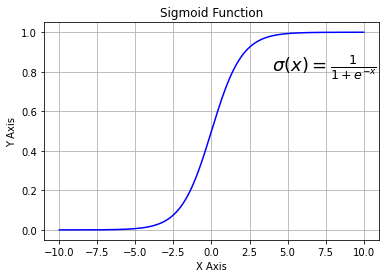

In [367]:
import matplotlib.pyplot as plt
sigmoid = lambda x: 1 / (1 + np.exp(-x))
x = np.linspace(-10,10,1000)

plt.plot(x,sigmoid(x),'b')
plt.grid()
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.title('Sigmoid Function')
plt.text(4,0.8,r'$\sigma(x)=\frac{1}{1+e^{-x}}$',fontsize=18)
plt.show()